In [ ]:
# Importamos los datos
!pip install onedrivedownloader
from onedrivedownloader import download

# **Importación de datos**

En todo proyecto de IA, comenzamos importando los datos y los paquetes necesarios. Los datos los importamos a través del onedrive subido al Canvas.

Cabe destacar que los paquetes, aunque aparecen importados en una única celda, los hemos ido importando a medida que hacíamos el trabajo. Tras finalizarlo, los hemos importado todos en una única celda para concentrar la información.

In [ ]:
url = 'https://universidadfv-my.sharepoint.com/:x:/g/personal/alberto_desantos_ufv_es/EYyohJiyYgdEgZQBuVAATOYBz_lWRPYAI5POI_E-YLiklA?rtime=HeKBzBRM3Ug'

download(url = url, filename = 'archivo.csv', force_download=True, clean=True)

100%|██████████| 193M/193M [00:04<00:00, 47.1MiB/s]


'archivo.csv'

In [ ]:
import pandas as pd

In [ ]:
raw_data = pd.read_csv('archivo.csv')

In [ ]:
raw_data["pais"] = raw_data["pais"].str.strip().str.upper()

# Lista de códigos de países europeos (ISO 3166-1 alfa-3)
paises_europeos = [
    "ESP", "FRA", "DEU", "ITA", "GBR", "NLD", "BEL", "PRT", "SWE", "NOR", "DNK",
    "FIN", "CHE", "AUT", "IRL", "POL", "CZE", "HUN", "ROU", "SVK", "SVN", "HRV",
    "SRB", "BGR", "GRC", "EST", "LVA", "LTU", "ISL", "MLT", "CYP", "UKR", "RUS"
]

# Filtrar solo los países europeos
raw_data = raw_data[raw_data['pais'].isin(paises_europeos)]

In [ ]:
# Nuevas importaciones para manejar Elo ratings
!pip install requests  # Install requests if not already installed
import requests
from io import StringIO
from datetime import datetime, timedelta

# Función para obtener datos Elo de una fecha específica
def fetch_elo_data(date):
    url = f"http://api.clubelo.com/{date}"
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"No se pudieron obtener datos Elo para {date}. Código de estado: {response.status_code}")
        return None

# Función para obtener el rating Elo de un equipo en una fecha específica
def get_elo_rating(team, date, elo_cache):
    # Calcular el día anterior a la fecha del partido
    day_before = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    # Si no está en caché, obtener los datos
    if day_before not in elo_cache:
        elo_cache[day_before] = fetch_elo_data(day_before)

    elo_data = elo_cache[day_before]
    if elo_data is not None:
        # Buscar el equipo (ignorar mayúsculas/minúsculas)
        team_elo = elo_data[elo_data['Club'].str.lower() == team.lower()]
        if not team_elo.empty:
            return team_elo['Elo'].iloc[0]
    return None  # Si no se encuentra, devolver None

# Verificar si existe una columna de fecha (asumimos 'fecha')
if 'timestamp_day' not in raw_data.columns:
    raise ValueError("No se encontró la columna 'fecha' en el DataFrame. Por favor, verifica el nombre de la columna de fecha.")

# Crear una copia del DataFrame para trabajar
df = raw_data

# Inicializar caché para datos Elo
elo_cache = {}

# Aplicar la función para obtener ratings Elo para equipos locales y visitantes
df['elo_local'] = df.apply(lambda row: get_elo_rating(row['equipo_local'], row['timestamp_day'].split()[0], elo_cache), axis=1)
df['elo_visit'] = df.apply(lambda row: get_elo_rating(row['equipo_visit'], row['timestamp_day'].split()[0], elo_cache), axis=1)

# Eliminar filas donde 'elo_local' o 'elo_visit' sean nulos
df.dropna(subset=['elo_local', 'elo_visit'], inplace=True)

# Reemplazar las columnas originales con los ratings Elo
df['equipo_local'] = df['elo_local']
df['equipo_visit'] = df['elo_visit']

# Eliminar columnas temporales si no las necesitas
df.drop(['elo_local', 'elo_visit'], axis=1, inplace=True)

# Mostrar las primeras filas para verificar
print("Datos actualizados con ratings Elo:")
print(df.head())

# Opcional: guardar el DataFrame actualizado
df.to_csv('datos_con_elo.csv', index=False)
print("Archivo guardado como 'datos_con_elo.csv'.")

In [ ]:
from google.colab import files
files.download('datos_con_elo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Importación paquetes y nuevo documento**

In [ ]:
import numpy as np
import pandas as pd
# Para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Para la preparación de los datos
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Modelos de ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error

In [ ]:
url = 'https://universidadfv-my.sharepoint.com/:x:/g/personal/9200616_alumnos_ufv_es/EUAr0MvNb8hLtrX1RfRQo90BfkCxmxUW85nHW2uZBklhsA?e=Ys7tEQ'

download(url = url, filename = 'soccer.csv', force_download=True, clean=True)

100%|██████████| 40.6M/40.6M [00:05<00:00, 7.54MiB/s]


'soccer.csv'

In [ ]:
raw_data = pd.read_csv('soccer.csv', sep=';')

<ipython-input-20-8d6445ac7d1d>:1: DtypeWarning: Columns (458,459,460) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('soccer.csv', sep=';')


# **Filtrado de información y visualización de los datos**

El primer paso imprescindible de todo modelo de Machine Learning, en especial cuándo uno cuenta con una gran cantidad de información (cómo es nuestro caso), es determinar qué información es útil para nuestro modelo y cuál es mero ruido.

Para ello, analizamos los datos de entrenamiento de: </p>

1. __Archivo CSV (*histórico diario*)__</p>
El archivo adjuntado a la tarea posee 465 columnas con un total de 182895 datos. Las primeras 338 columnas poseen valores de 0 para alrededor de las primeras 2660 filas. Esto a efectos prácticos se traduce a que el análisis estadístico (máximo, mínimo y mediana) del lustro anterior no se estudia hasta mediados del año 2001. Además, varias columnas presentan valores constantes. Por ejemplo, la columna "periodo" presenta el mismo valor a lo largo de todo el documento, nt; y la columna "resultado target" hace lo mismo con el valor 2.

2. __Competición de kaggle similar (*Football Match Prediction*)__</p>
En esta competición, para predecir el resultado de un partido de fútbol aleatorio, utilizan como variables de entrenamiento las que se muestran en la sección "Predicting the Winning Team" (https://www.kaggle.com/code/saife245/football-match-prediction).

Al comparar ambos datasets, decidimos emplear inicialmente 10-20 variables para el entrenamiento, e ir añadiendo más variables conforme vayamos viendo necesario.

In [ ]:
raw_data.shape

(38432, 465)

In [ ]:
# Filtrar las filas donde "raw_odd_gana_visit" NO sea 0.0
filtered_data_1 = raw_data[raw_data['raw_odd_gana_local'] != 0.0]

filtered_data_1.shape

(36384, 465)

In [ ]:
# Lista de columnas a eliminar
columns_to_drop = ["resultado_target", "goles_local", "goles_visit"]

# Agregar columnas que terminan en "max" o "min"
columns_to_drop.extend([col for col in filtered_data_1.columns if col.endswith("median") or col.endswith("max") or col.endswith("min")])


# También eliminar cualquier columna que contenga "Unnamed"
columns_to_drop.extend([col for col in filtered_data_1.columns if "Unnamed" in col])

# Eliminar las columnas especificadas
filtered_data_2 = filtered_data_1.drop(columns=columns_to_drop)

# Mostrar las primeras filas
filtered_data_2.head()

,LOC_Primera,VIS_Primera,LOC_PerderVisitDiff3,LOC_PerderVisitDiff2,LOC_PerderLocalDiff3,LOC_PerderLocalDiff2,LOC_GanarVisitDiff3,LOC_GanarVisitDiff2,LOC_GanarLocalDiff3,LOC_GanarLocalDiff2,...,jornada,periodo,timestamp,raw_odd_gana_local,raw_odd_gana_visit,raw_odd_empatar,equipo_local,equipo_visit,pais,timestamp_day
2048,1,1,5,7,1,4,0,1,1,4,...,30,nt,2002-04-07 18:00:00+00:00,0,0,0,"1639,306152","1709,242676",DEU,7/4/02
2049,0,1,0,1,1,2,0,1,1,5,...,30,nt,2002-04-07 18:00:00+00:00,0,0,0,"1660,68689","1745,795898",ITA,7/4/02
2050,1,1,0,0,0,1,1,4,2,6,...,30,nt,2002-04-07 18:00:00+00:00,0,0,0,"1826,515747","1643,540527",ITA,7/4/02
2051,1,1,0,4,1,1,1,1,3,6,...,30,nt,2002-04-07 18:00:00+00:00,0,0,0,"1757,230103","1587,373535",ITA,7/4/02
2052,1,1,3,6,0,1,0,1,0,5,...,30,nt,2002-04-07 18:00:00+00:00,0,0,0,"1651,615601","1836,466309",ITA,7/4/02


In [ ]:
# Reemplazar valores en 'resultado'
filtered_data_2['resultado'] = filtered_data_2['resultado'].replace({'X': 0}).astype(int)

# Columnas iniciales
columnas_iniciales = ['resultado']

# Obtener columnas de tipo int y float
columnas_int = filtered_data_2.select_dtypes(include=['int64']).columns.tolist()
columnas_float = filtered_data_2.select_dtypes(include=['float64']).columns.tolist()

# Crear la lista final manteniendo el orden y eliminando duplicados
columnas_union = list(dict.fromkeys(columnas_iniciales + columnas_int + columnas_float))

# Filtrar el DataFrame
filtered_data_3 = filtered_data_2[columnas_union]

# Mostrar primeras filas
filtered_data_3.head()

,resultado,LOC_Primera,VIS_Primera,LOC_PerderVisitDiff3,LOC_PerderVisitDiff2,LOC_PerderLocalDiff3,LOC_PerderLocalDiff2,LOC_GanarVisitDiff3,LOC_GanarVisitDiff2,LOC_GanarLocalDiff3,...,VIS_DiferenciaPuntosClasificacionEquipoSiguiente,VIS_NumeroPuntosClasificacion,VIS_PosicionClasificacion,VIS_NumPartidosMarcandoVisit,VIS_NumPartidosMarcandoLocal,VIS_GolesContraVisit,VIS_GolesFavorVisit,VIS_GolesContraLocal,VIS_GolesFavorLocal,jornada
2048,2,1,1,5,7,1,4,0,1,1,...,4,41,9,8,9,22,15,13,21,30
2049,0,0,1,0,1,1,2,0,1,1,...,1,47,5,11,10,16,19,14,22,30
2050,2,1,1,0,0,0,1,1,4,2,...,2,37,10,9,12,23,15,21,19,30
2051,1,1,1,0,4,1,1,1,1,3,...,5,27,16,12,11,27,16,19,16,30
2052,2,1,1,3,6,0,1,0,1,0,...,8,56,3,9,13,12,19,11,32,30


In [ ]:
def eliminar_comas():
  for col in filtered_data_3.columns:
    if filtered_data_3[col].dtype == 'object':
      filtered_data_3[col] = filtered_data_3[col].str.replace(',', '.').astype(float)

  return filtered_data_3

In [ ]:
df = eliminar_comas()

df.head()

,resultado,LOC_Primera,VIS_Primera,LOC_PerderVisitDiff3,LOC_PerderVisitDiff2,LOC_PerderLocalDiff3,LOC_PerderLocalDiff2,LOC_GanarVisitDiff3,LOC_GanarVisitDiff2,LOC_GanarLocalDiff3,...,VIS_DiferenciaPuntosClasificacionEquipoSiguiente,VIS_NumeroPuntosClasificacion,VIS_PosicionClasificacion,VIS_NumPartidosMarcandoVisit,VIS_NumPartidosMarcandoLocal,VIS_GolesContraVisit,VIS_GolesFavorVisit,VIS_GolesContraLocal,VIS_GolesFavorLocal,jornada
2048,2,1,1,5,7,1,4,0,1,1,...,4,41,9,8,9,22,15,13,21,30
2049,0,0,1,0,1,1,2,0,1,1,...,1,47,5,11,10,16,19,14,22,30
2050,2,1,1,0,0,0,1,1,4,2,...,2,37,10,9,12,23,15,21,19,30
2051,1,1,1,0,4,1,1,1,1,3,...,5,27,16,12,11,27,16,19,16,30
2052,2,1,1,3,6,0,1,0,1,0,...,8,56,3,9,13,12,19,11,32,30


# **Solución en base a los datos**

In [ ]:
def potencial_beneficio(df):
    resultados = {
        "Victoria Local": "raw_odd_gana_local",
        "Victoria Visitante": "raw_odd_gana_visit",
        "Empate": "raw_odd_empatar"
    }
    for resultado, columna in resultados.items():
        mean_val = df[columna].mean().round(2)
        std_val = df[columna].std().round(2)
        max_val = df[columna].max()
        min_val = df[columna].min()

        print(f'=== {resultado} ===')
        print(f'Beneficio: {mean_val} más/menos {std_val}')
        print(f'Máximo: {max_val} | Mínimo: {min_val}')
        print()  # Empty line for better separation

potencial_beneficio(filtered_data_2)

=== Victoria Local ===
Beneficio: 2.76 más/menos 2.43
Máximo: 102.8 | Mínimo: 1.0

=== Victoria Visitante ===
Beneficio: 4.4 más/menos 3.89
Máximo: 96.59 | Mínimo: -8.6

=== Empate ===
Beneficio: 3.86 más/menos 1.26
Máximo: 24.4 | Mínimo: -3.75



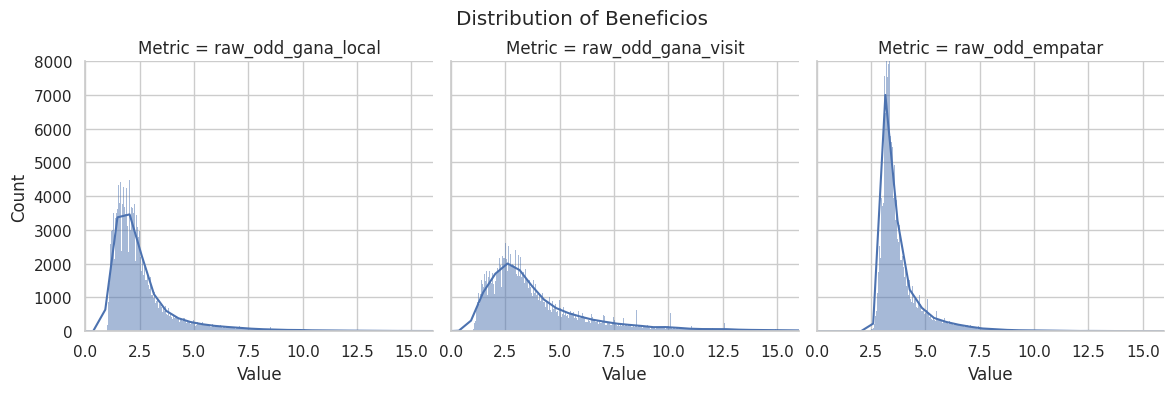

In [ ]:
def potencial_beneficio(df):
    metrics = ["raw_odd_gana_local", "raw_odd_gana_visit", "raw_odd_empatar"]

    df_melted = pd.melt(df, value_vars=metrics, var_name="Metric", value_name="Value")

    g = sns.displot(
        data=df_melted,
        x="Value",
        col="Metric",
        kde=True,
        height=4,
        aspect=1
    )

    for ax in g.axes.flatten():
        ax.set_xlim(0, 16)
        ax.set_ylim(0, 8000)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Distribution of Beneficios")
    plt.show()

potencial_beneficio(filtered_data_2)

# **Entrenamiento**

En esta fase del modelo, vamos a definir las variables de entrenamiento, así cómo la variable _target_. __X__ es el conjunto de variables de entrenamiento, en nuestro caso son todas las columnas del documento cuyos datos son de tipo _int_, además de las columnas formadas a partir de la variable "pais". __y__ por el contrario es la columna modificada de "resultado".

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

df = filtered_data_3

X = df.drop(columns=["resultado"])
y = df["resultado"]
"""
# Assuming X is your feature matrix and y is your target variable
df_entrenamiento = pd.concat([X, y], axis=1)  # Combine features and target into one DataFrame

# Define the number of samples per class
n_samples = df_entrenamiento['resultado'].value_counts().min()  # Smallest class size

# Sample an equal number of instances per class
df_balanced = df_entrenamiento.groupby('resultado').apply(lambda x: x.sample(n_samples, random_state=42)).reset_index(drop=True)

# Separate X and y again
X_balanced = df_balanced.drop(columns=['resultado'])
y_balanced = df_balanced['resultado']
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# Scale the cleaned data
scaler = RobustScaler().fit(X_train)
features_train_scaled = scaler.transform(X_train)
features_test_scaled = scaler.transform(X_test)

In [ ]:
def analisis_entrenamiento(n):
  Y_pred = n.predict(X_test)

  from sklearn.metrics import confusion_matrix, classification_report
  cm = confusion_matrix(y_test, Y_pred)

  sns.heatmap(cm, annot=True,fmt='d')

  print(classification_report(y_test, Y_pred))

In [ ]:
!pip install optuna
!pip install --upgrade xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = RandomForestClassifier(n_estimators=100, **params, random_state=42)
    # Use cross-validation for robust evaluation
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Random Forest Tree Parameters:", study.best_params)

[I 2025-03-06 12:49:43,232] A new study created in memory with name: no-name-207768df-198c-40db-986e-8f70bafdb47d
[I 2025-03-06 12:50:02,282] Trial 0 finished with value: 0.6177166200817028 and parameters: {'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6177166200817028.
[I 2025-03-06 12:50:13,049] Trial 1 finished with value: 0.6158245538593851 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6177166200817028.
[I 2025-03-06 12:50:39,328] Trial 2 finished with value: 0.6117394108793807 and parameters: {'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.6177166200817028.
[I 2025-03-06 12:50:48,663] Trial 3 finished with value: 0.6165985809503333 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 0 

KeyboardInterrupt: 

# **Random Forest**

In [ ]:
#fitting the RANDOM FOREST to the training se

model_RF = RandomForestClassifier(n_estimators=2000, random_state=1, class_weight="balanced")
model_RF.fit(features_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=2000,
                       random_state=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           1       0.45      1.00      0.62      4919
           2       0.61      0.01      0.02      3138
           3       0.00      0.00      0.00      2859

    accuracy                           0.45     10916
   macro avg       0.35      0.34      0.21     10916
weighted avg       0.38      0.45      0.29     10916



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


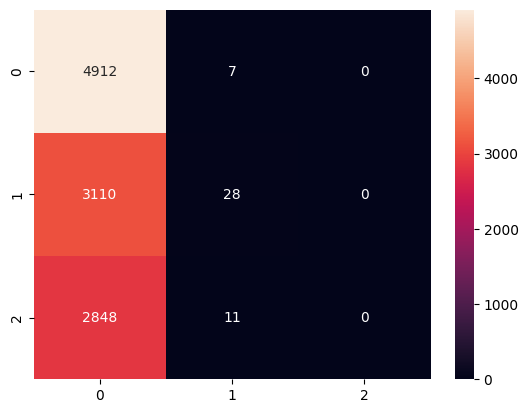

In [ ]:
analisis_entrenamiento(model_RF)

# **SVM**

In [ ]:
#fitting the SVM to the training set
from sklearn.svm import SVC
model_SVM = SVC(kernel = 'rbf',random_state = 1)
model_SVM.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
analisis_entrenamiento(model_SVM)

# **XGBoost**

In [ ]:
# Fitting XGBoost to the Training set

model_XGB = XGBClassifier(seed=1, class_weight="balanced")
model_XGB.fit(features_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:17:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       0.26      0.69      0.38      2859
           1       0.42      0.19      0.26      4919
           2       0.35      0.13      0.19      3138

    accuracy                           0.30     10916
   macro avg       0.34      0.34      0.28     10916
weighted avg       0.36      0.30      0.27     10916



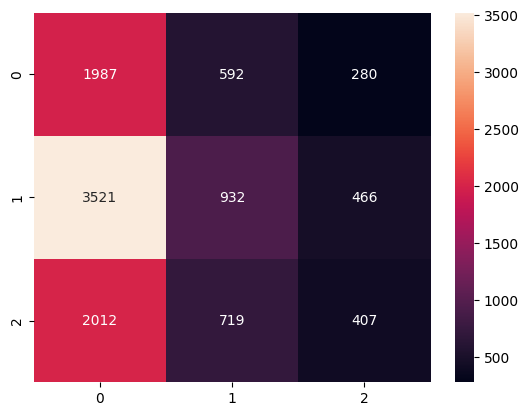

In [ ]:
analisis_entrenamiento(model_XGB)

# **Logistic Regression**

In [ ]:
# Fitting Logistic Regression to the Training set

model_LR = LogisticRegression(random_state = 0)
model_LR.fit(features_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

              precision    recall  f1-score   support

           0       0.28      0.66      0.40      2859
           1       0.65      0.32      0.43      4919
           2       0.49      0.30      0.37      3138

    accuracy                           0.40     10916
   macro avg       0.48      0.43      0.40     10916
weighted avg       0.51      0.40      0.40     10916



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


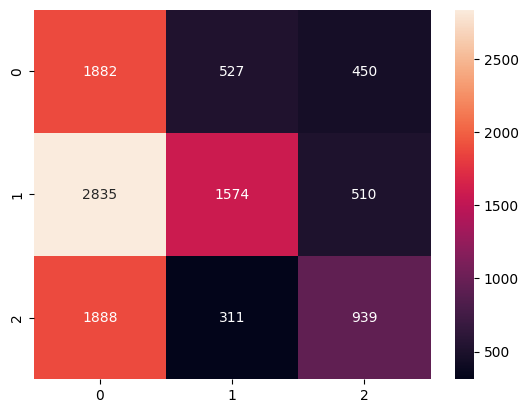

In [ ]:
analisis_entrenamiento(model_LR)

# **Deep Neural Network (v3)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adagrad
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Define the model with Batch Normalization
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    BatchNormalization(),  # Batch Norm before activation
    tf.keras.layers.Activation('relu'),
    Dropout(0.3),

    Dense(128),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.3),

    Dense(64),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.3),

    Dense(32),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer=Adagrad(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.5228 - loss: 0.7826 - val_accuracy: 0.6321 - val_loss: 0.6315
Epoch 2/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5844 - loss: 0.6915 - val_accuracy: 0.6335 - val_loss: 0.6251
Epoch 3/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5965 - loss: 0.6793 - val_accuracy: 0.6352 - val_loss: 0.6229
Epoch 4/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6016 - loss: 0.6731 - val_accuracy: 0.6381 - val_loss: 0.6212
Epoch 5/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.6695 - val_accuracy: 0.6387 - val_loss: 0.6201
Epoch 6/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6059 - loss: 0.6636 - val_accuracy: 0.6389 - val_loss: 0.6191
Epoch 7/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6096 - loss: 0.6612 - val_accuracy: 0.6391 - val_loss: 0.6183
Epoch 8/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6057 - los

947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


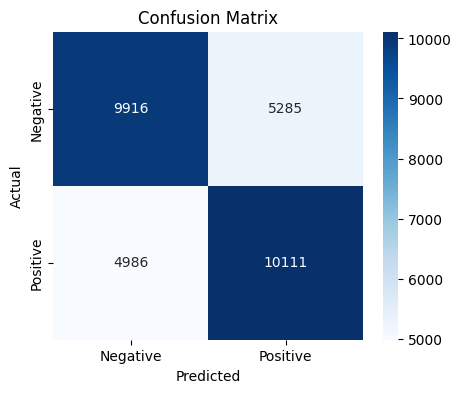

              precision    recall  f1-score   support

           0       0.67      0.65      0.66     15201
           1       0.66      0.67      0.66     15097

    accuracy                           0.66     30298
   macro avg       0.66      0.66      0.66     30298
weighted avg       0.66      0.66      0.66     30298



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted probabilities
Y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions
Y_pred = (Y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, Y_pred))


# **Beneficios económicos**

Tomamos el modelo con mayor precisión para la victoria del equipo rival

In [ ]:
# Select only the values from 'col_name' that are greater than 0.0
filtered_values = raw_data.loc[raw_data['raw_odd_gana_local'] > 0.0, 'raw_odd_gana_local']


max_value = filtered_values.dropna().max()
min_value = filtered_values.dropna().min()
avg_value = filtered_values.dropna().mean()

print(max_value)
print(min_value)
print(avg_value)

102.8
1.0
2.761843137022998


In [ ]:
# Select only the values from 'col_name' that are greater than 0.0
filtered_values = raw_data.loc[raw_data['raw_odd_gana_visit'] > 0.0, 'raw_odd_gana_visit']


max_value = filtered_values.dropna().max()
min_value = filtered_values.dropna().min()
avg_value = filtered_values.dropna().mean()

print(max_value)
print(min_value)
print(avg_value)

96.59
1.0
4.403422254024199


In [ ]:
# Select only the values from 'col_name' that are greater than 0.0
filtered_values = raw_data.loc[raw_data['raw_odd_empatar'] > 0.0, 'raw_odd_empatar']


max_value = filtered_values.dropna().max()
min_value = filtered_values.dropna().min()
avg_value = filtered_values.dropna().mean()

print(max_value)
print(min_value)
print(avg_value)

24.4
1.0
3.8590397511561076
